In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import datetime
import os
from fancyimpute import KNN

imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

In [11]:
type(pd.to_datetime('2017-01-01'))

pandas._libs.tslib.Timestamp

In [18]:

df = pd.read_csv('ListingsAndSales.csv',parse_dates=['ListingDate', 'SalesDate'])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import os
from fancyimpute import KNN

imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

df = pd.read_csv('ListingsAndSales.csv')

# not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull() == True, 'NotSoldFlag'] = 1
print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate, df.SalesDate = [
    pd.to_datetime(col) for col in [df.ListingDate, df.SalesDate]
]
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

# Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

# calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

# loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']

# Columns to use as regressors
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Use 3 nearest rows which have a feature to fill in each row's missing features
scaler = StandardScaler()
nan_vals = np.isnan(X)
for col in X.columns:
    nan_vals_col = np.isnan(X[col])
    X.loc[nan_vals_col,col] = X[col].mean()

X = scaler.fit_transform(X)
X[nan_vals] = np.nan
X = pd.DataFrame(KNN(k=5).complete(X))

# Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X)).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)
n_features = X.shape[1]


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, trn_samples, bs, X_train, Y_train, sold_train):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.loss, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    def train(self, X, Y, sold, epochs):
        # Train the model based on X,Y,sold data for a set number of epochs
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        bs = 64
        
        # Let's randomly split the data here between train and test.
        # We will do better in a later version.
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]

        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(trn_samples, bs, X_train, Y_train, sold_train)
            self.validate(X_test, Y_test, sold_test)
            
            if epoch % 10 == 0:
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])

    def visualize(self, name):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()


epoch: 0 train loss:  715.1794 val loss:  729.9868 r2_score: -0.07961252740655356
epoch: 10 train loss:  679.28735 val loss:  684.0993 r2_score: -0.018403822692102834
epoch: 20 train loss:  637.78625 val loss:  636.7237 r2_score: 0.045248569909908665
epoch: 30 train loss:  599.89044 val loss:  594.22925 r2_score: 0.10360062453521901
epoch: 40 train loss:  564.487 val loss:  556.46826 r2_score: 0.15612717469585669
epoch: 50 train loss:  533.5403 val loss:  522.6487 r2_score: 0.20360146250096012
epoch: 60 train loss:  506.38864 val loss:  490.9426 r2_score: 0.2464369639387588
epoch: 70 train loss:  481.24207 val loss:  463.68564 r2_score: 0.2853906269461436
epoch: 80 train loss:  459.59418 val loss:  439.0454 r2_score: 0.3206200689952269
epoch: 90 train loss:  439.01593 val loss:  416.4681 r2_score: 0.35259250475238635


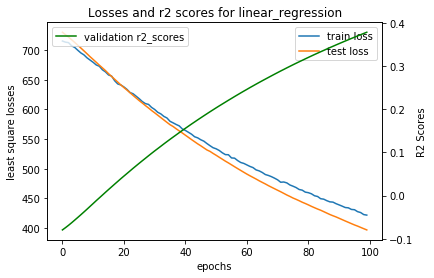

In [6]:
model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')

epoch: 0 train loss:  704.53973 val loss:  742.9681 r2_score: -0.04499755139122619
epoch: 10 train loss:  226.04402 val loss:  228.54402 r2_score: 0.6418933967676439
epoch: 20 train loss:  189.60487 val loss:  185.97255 r2_score: 0.6958745099688739
epoch: 30 train loss:  185.7364 val loss:  180.78241 r2_score: 0.7011824498301958
epoch: 40 train loss:  184.22824 val loss:  178.8388 r2_score: 0.7030528543560943
epoch: 50 train loss:  182.58626 val loss:  178.20718 r2_score: 0.7046268131435026
epoch: 60 train loss:  182.45471 val loss:  178.5488 r2_score: 0.7054892755823409
epoch: 70 train loss:  181.61383 val loss:  177.48659 r2_score: 0.7063977178676746
epoch: 80 train loss:  180.52666 val loss:  177.25719 r2_score: 0.7071342976253173
epoch: 90 train loss:  181.21468 val loss:  176.7639 r2_score: 0.7079686288520485


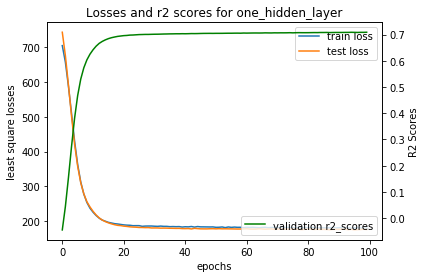

In [7]:
model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')

epoch: 0 train loss:  685.2559 val loss:  604.1096 r2_score: 0.07018902212202827
epoch: 10 train loss:  189.76543 val loss:  157.74214 r2_score: 0.7133362674019207
epoch: 20 train loss:  185.92628 val loss:  155.34656 r2_score: 0.7180825376772683
epoch: 30 train loss:  184.92503 val loss:  153.18622 r2_score: 0.7199015341986437
epoch: 40 train loss:  182.36394 val loss:  151.02525 r2_score: 0.7220614596087341
epoch: 50 train loss:  181.72054 val loss:  155.32053 r2_score: 0.7198218646652488
epoch: 60 train loss:  180.9423 val loss:  149.92227 r2_score: 0.7241118892244709
epoch: 70 train loss:  179.37543 val loss:  152.72269 r2_score: 0.7233215868805296
epoch: 80 train loss:  178.0623 val loss:  152.7704 r2_score: 0.7238714659595638
epoch: 90 train loss:  176.99577 val loss:  153.4252 r2_score: 0.7240574140482197


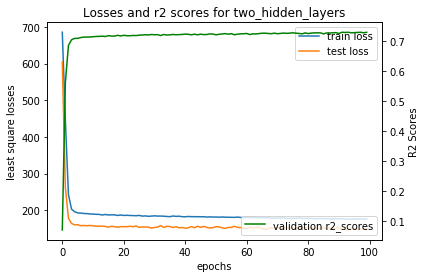

In [8]:
model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('two_hidden_layers')